# Process Tweets
Cleaning and analysis of current data

In [ ]:
# Local imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re
import nltk
import string
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.express as px
import datetime
import time
import emoji
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
np.random.seed(0)

%matplotlib inline

### Import the pickled data

In [8]:
# Load tweet dataframe
df = pickle.load( open( "twitter_df.p", "rb" ) )
df.head()

,_id,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,entities,favorited,retweeted,filter_level,lang,timestamp_ms,display_text_range,extended_tweet,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_entities,withheld_in_countries
0,5ea86e63f62c72daf5bbcc93,Tue Apr 28 17:56:45 +0000 2020,1255194256937046018,1255194256937046018,"RT @threadreaderapp: @TimeMayHeal Bonjour, the...","<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,None,"{'id': 22647819, 'id_str': '22647819', 'name':...",None,None,None,None,{'created_at': 'Tue Apr 28 17:36:46 +0000 2020...,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1588096605892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5ea86e9af62c72daf5bbcc94,Tue Apr 28 17:57:41 +0000 2020,1255194489511202816,1255194489511202816,RT @mitchellvii: I don't care if COVID-19 had ...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,"{'id': 1050871427979730944, 'id_str': '1050871...",None,None,None,None,{'created_at': 'Tue Apr 28 16:49:28 +0000 2020...,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1588096661342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5ea86ed5f62c72daf5bbcc95,Tue Apr 28 17:58:40 +0000 2020,1255194736991797250,1255194736991797250,Act now and call on the President to take back...,"<a href=""http://phone2action.com"" rel=""nofollo...",True,NaN,None,NaN,None,None,"{'id': 930743156, 'id_str': '930743156', 'name...",None,None,None,None,NaN,False,0,0,0,0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",False,False,low,en,1588096720346,"[0, 140]",{'full_text': 'Act now and call on the Preside...,True,NaN,NaN,NaN,NaN,NaN,NaN
3,5ea86ed5f62c72daf5bbcc96,Tue Apr 28 17:58:40 +0000 2020,1255194737604268034,1255194737604268034,A dream,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,"{'id': 34645167, 'id_str': '34645167', 'name':...",None,None,None,None,NaN,True,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1588096720492,NaN,NaN,NaN,1.255107e+18,1255106762736271363,{'created_at': 'Tue Apr 28 12:09:05 +0000 2020...,"{'url': 'https://t.co/yHhlc5ii47', 'expanded':...",NaN,NaN
4,5ea86ed5f62c72daf5bbcc97,Tue Apr 28 17:58:40 +0000 2020,1255194737578872832,1255194737578872832,pelo amor de deus eu vo passar mal,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,"{'id': 883122567262896128, 'id_str': '88312256...",None,None,None,None,NaN,True,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,pt,1588096720486,NaN,NaN,NaN,1.255182e+18,1255182474231103490,{'created_at': 'Tue Apr 28 17:09:56 +0000 2020...,"{'url': 'https://t.co/LJAu0IA4MB', 'expanded':...",NaN,NaN


# Prepare the entire_text column 
Will also 
* show all columns
* create an entire_text column to contain all truncated tweets

## Add full text column in "entire_text"

In [9]:
# Show all columns for inspection
pd.set_option('display.max_columns', None)

# Create new column for entire text with original text column
df['entire_text'] = df.text

# If tweet is truncated, add full text
for lng_twt, bool_value, txt in zip(df['extended_tweet'], df['truncated'], df['entire_text']):
    if bool_value == True:
        txt = lng_twt

df.head()

,_id,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,entities,favorited,retweeted,filter_level,lang,timestamp_ms,display_text_range,extended_tweet,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_entities,withheld_in_countries,entire_text
0,5ea86e63f62c72daf5bbcc93,Tue Apr 28 17:56:45 +0000 2020,1255194256937046018,1255194256937046018,"RT @threadreaderapp: @TimeMayHeal Bonjour, the...","<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,None,"{'id': 22647819, 'id_str': '22647819', 'name':...",None,None,None,None,{'created_at': 'Tue Apr 28 17:36:46 +0000 2020...,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1588096605892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"RT @threadreaderapp: @TimeMayHeal Bonjour, the..."
1,5ea86e9af62c72daf5bbcc94,Tue Apr 28 17:57:41 +0000 2020,1255194489511202816,1255194489511202816,RT @mitchellvii: I don't care if COVID-19 had ...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,"{'id': 1050871427979730944, 'id_str': '1050871...",None,None,None,None,{'created_at': 'Tue Apr 28 16:49:28 +0000 2020...,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1588096661342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT @mitchellvii: I don't care if COVID-19 had ...
2,5ea86ed5f62c72daf5bbcc95,Tue Apr 28 17:58:40 +0000 2020,1255194736991797250,1255194736991797250,Act now and call on the President to take back...,"<a href=""http://phone2action.com"" rel=""nofollo...",True,NaN,None,NaN,None,None,"{'id': 930743156, 'id_str': '930743156', 'name...",None,None,None,None,NaN,False,0,0,0,0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",False,False,low,en,1588096720346,"[0, 140]",{'full_text': 'Act now and call on the Preside...,True,NaN,NaN,NaN,NaN,NaN,NaN,Act now and call on the President to take back...
3,5ea86ed5f62c72daf5bbcc96,Tue Apr 28 17:58:40 +0000 2020,1255194737604268034,1255194737604268034,A dream,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,"{'id': 34645167, 'id_str': '34645167', 'name':...",None,None,None,None,NaN,True,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1588096720492,NaN,NaN,NaN,1.255107e+18,1255106762736271363,{'created_at': 'Tue Apr 28 12:09:05 +0000 2020...,"{'url': 'https://t.co/yHhlc5ii47', 'expanded':...",NaN,NaN,A dream
4,5ea86ed5f62c72daf5bbcc97,Tue Apr 28 17:58:40 +0000 2020,1255194737578872832,1255194737578872832,pelo amor de deus eu vo passar mal,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,"{'id': 883122567262896128, 'id_str': '88312256...",None,None,None,None,NaN,True,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,pt,1588096720486,NaN,NaN,NaN,1.255182e+18,1255182474231103490,{'created_at': 'Tue Apr 28 17:09:56 +0000 2020...,"{'url': 'https://t.co/LJAu0IA4MB', 'expanded':...",NaN,NaN,pelo amor de deus eu vo passar mal


## Data Summaries

In [10]:
df.isna().sum()

_id                               0
created_at                        0
id                                0
id_str                            0
text                              0
source                            0
truncated                         0
in_reply_to_status_id        215730
in_reply_to_status_id_str    215730
in_reply_to_user_id          213635
in_reply_to_user_id_str      213635
in_reply_to_screen_name      213635
user                              0
geo                          231432
coordinates                  231432
place                        229502
contributors                 231542
retweeted_status              67075
is_quote_status                   0
quote_count                       0
reply_count                       0
retweet_count                     0
favorite_count                    0
entities                          0
favorited                         0
retweeted                         0
filter_level                      0
lang                        

In [17]:
# Drop columns personally deemed unnecessary
df = df.drop(['_id', 'id_str', 'user', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
              'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'quote_count', 'retweet_count', 'favorite_count', 
              'entities', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink', 'contributors', 
              'extended_entities'],
       axis=1)
df.head()

,created_at,id,text,source,truncated,geo,coordinates,place,retweeted_status,is_quote_status,reply_count,favorited,retweeted,filter_level,lang,timestamp_ms,display_text_range,extended_tweet,possibly_sensitive,quoted_status,withheld_in_countries,entire_text
0,Tue Apr 28 17:56:45 +0000 2020,1255194256937046018,"RT @threadreaderapp: @TimeMayHeal Bonjour, the...","<a href=""http://twitter.com/download/android"" ...",False,None,None,None,{'created_at': 'Tue Apr 28 17:36:46 +0000 2020...,False,0,False,False,low,en,1588096605892,NaN,NaN,NaN,NaN,NaN,"RT @threadreaderapp: @TimeMayHeal Bonjour, the..."
1,Tue Apr 28 17:57:41 +0000 2020,1255194489511202816,RT @mitchellvii: I don't care if COVID-19 had ...,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,{'created_at': 'Tue Apr 28 16:49:28 +0000 2020...,False,0,False,False,low,en,1588096661342,NaN,NaN,NaN,NaN,NaN,RT @mitchellvii: I don't care if COVID-19 had ...
2,Tue Apr 28 17:58:40 +0000 2020,1255194736991797250,Act now and call on the President to take back...,"<a href=""http://phone2action.com"" rel=""nofollo...",True,None,None,None,NaN,False,0,False,False,low,en,1588096720346,"[0, 140]",{'full_text': 'Act now and call on the Preside...,True,NaN,NaN,Act now and call on the President to take back...
3,Tue Apr 28 17:58:40 +0000 2020,1255194737604268034,A dream,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,NaN,True,0,False,False,low,en,1588096720492,NaN,NaN,NaN,{'created_at': 'Tue Apr 28 12:09:05 +0000 2020...,NaN,A dream
4,Tue Apr 28 17:58:40 +0000 2020,1255194737578872832,pelo amor de deus eu vo passar mal,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,NaN,True,0,False,False,low,pt,1588096720486,NaN,NaN,NaN,{'created_at': 'Tue Apr 28 17:09:56 +0000 2020...,NaN,pelo amor de deus eu vo passar mal


In [5]:
len(df)

231542

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231542 entries, 0 to 231541
Data columns (total 39 columns):
_id                          231542 non-null object
created_at                   231542 non-null object
id                           231542 non-null int64
id_str                       231542 non-null object
text                         231542 non-null object
source                       231542 non-null object
truncated                    231542 non-null bool
in_reply_to_status_id        15812 non-null float64
in_reply_to_status_id_str    15812 non-null object
in_reply_to_user_id          17907 non-null float64
in_reply_to_user_id_str      17907 non-null object
in_reply_to_screen_name      17907 non-null object
user                         231542 non-null object
geo                          110 non-null object
coordinates                  110 non-null object
place                        2040 non-null object
contributors                 0 non-null object
retweeted_status        

# Tweet times
Tweet time information
* Time of 1st tweet
* Time of last tweet
* Time difference of first to last tweet

In [7]:
# Find time of tweet information
first = np.min(df.timestamp_ms.astype(int))
last = np.max(df.timestamp_ms.astype(int))
time_diff = last - first

print('First tweet occurs at {} ms.\nLast tweet occurs at {} ms.'.format(first, last))
print('Time difference between first and last tweet {} ms.'.format(time_diff))


First tweet occurs at 1588096605892 ms.
Last tweet occurs at 1588197661405 ms.
Time difference between first and last tweet 101055513 ms.


In [82]:
# Convert timestamp in ms to date/time
first_date = datetime.datetime.fromtimestamp(first/1000.0).strftime('%Y-%m-%d %H:%M:%S.%f')
last_date = datetime.datetime.fromtimestamp(last/1000.0).strftime('%Y-%m-%d %H:%M:%S.%f')

print('First tweet occurs at {} ms.\nLast tweet occurs at {} ms.'.format(first_date, last_date))


First tweet occurs at 2020-04-28 13:56:45.892000 ms.
Last tweet occurs at 2020-04-29 18:01:01.405000 ms.


## Began collecting tweets on 4/28/2020 at 1:56 pm continuing off and on until 4/29/2020 at 1:01 pm.

# Visualize the source of each tweet

In [84]:
# Function to find sources
def get_source_name(x):
    value = re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)
    if len(value) > 0:
        return value[0]
    else:
        return ""

/Users/shirlwilliams/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



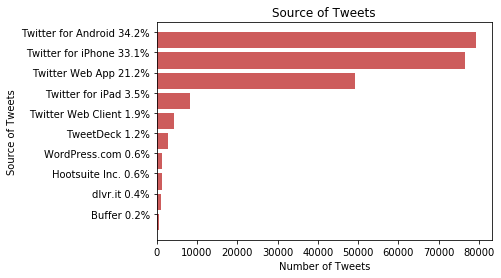

Buffer                   532
dlvr.it                  986
Hootsuite Inc.          1274
WordPress.com           1275
TweetDeck               2829
Twitter Web Client      4306
Twitter for iPad        8126
Twitter Web App        49149
Twitter for iPhone     76572
Twitter for Android    79234
Name: source, dtype: int64

In [85]:
# Find counts by tweet device and make a representative chart
df.source_name = df.source.apply(get_source_name)

# List of sources and their counts
source_counts = df.source_name.value_counts().sort_values()[-10:]

# Visual of source counts
bottom = [index for index, item in enumerate(source_counts.index)]
plt.barh(bottom, width=source_counts, color="indianred", linewidth=0)
y_labels = ["%s %.1f%%" % (item, 100.0*source_counts[item]/len(df)) for index,item in enumerate(source_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)
plt.title("Source of Tweets")
plt.xlabel("Number of Tweets")
plt.ylabel("Source of Tweets")
plt.show()
source_counts


# Tweet Lengths
Find more about the lengths of tweets.

In [19]:
# Find text lengths and add to dataset
df["text_length"] = df.entire_text.apply(len)
df.head(5)

,created_at,id,text,source,truncated,geo,coordinates,place,retweeted_status,is_quote_status,reply_count,favorited,retweeted,filter_level,lang,timestamp_ms,display_text_range,extended_tweet,possibly_sensitive,quoted_status,withheld_in_countries,entire_text,text_length
0,Tue Apr 28 17:56:45 +0000 2020,1255194256937046018,"RT @threadreaderapp: @TimeMayHeal Bonjour, the...","<a href=""http://twitter.com/download/android"" ...",False,None,None,None,{'created_at': 'Tue Apr 28 17:36:46 +0000 2020...,False,0,False,False,low,en,1588096605892,NaN,NaN,NaN,NaN,NaN,"RT @threadreaderapp: @TimeMayHeal Bonjour, the...",140
1,Tue Apr 28 17:57:41 +0000 2020,1255194489511202816,RT @mitchellvii: I don't care if COVID-19 had ...,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,{'created_at': 'Tue Apr 28 16:49:28 +0000 2020...,False,0,False,False,low,en,1588096661342,NaN,NaN,NaN,NaN,NaN,RT @mitchellvii: I don't care if COVID-19 had ...,140
2,Tue Apr 28 17:58:40 +0000 2020,1255194736991797250,Act now and call on the President to take back...,"<a href=""http://phone2action.com"" rel=""nofollo...",True,None,None,None,NaN,False,0,False,False,low,en,1588096720346,"[0, 140]",{'full_text': 'Act now and call on the Preside...,True,NaN,NaN,Act now and call on the President to take back...,140
3,Tue Apr 28 17:58:40 +0000 2020,1255194737604268034,A dream,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,NaN,True,0,False,False,low,en,1588096720492,NaN,NaN,NaN,{'created_at': 'Tue Apr 28 12:09:05 +0000 2020...,NaN,A dream,7
4,Tue Apr 28 17:58:40 +0000 2020,1255194737578872832,pelo amor de deus eu vo passar mal,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,NaN,True,0,False,False,low,pt,1588096720486,NaN,NaN,NaN,{'created_at': 'Tue Apr 28 17:09:56 +0000 2020...,NaN,pelo amor de deus eu vo passar mal,34


In [93]:
# Tweet length info
mean_length = np.mean(df.text_length)
min_length = np.min(df.text_length)
max_length = np.max(df.text_length)

print('Tweet Info\nMean Length: {:.2f}\nMin Length: {}\nMax Length: {}'.format(mean_length, min_length, max_length))

Tweet Info
Mean Length: 123.26
Min Length: 1
Max Length: 158


### The average tweet length is 123 characters.

In [20]:
# Tweets with 1 charachter
short = df[df['text_length']==1]
short

,created_at,id,text,source,truncated,geo,coordinates,place,retweeted_status,is_quote_status,reply_count,favorited,retweeted,filter_level,lang,timestamp_ms,display_text_range,extended_tweet,possibly_sensitive,quoted_status,withheld_in_countries,entire_text,text_length
4202,Tue Apr 28 18:00:04 +0000 2020,1255195088378040320,👇,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,NaN,True,0,False,False,low,und,1588096804123,NaN,NaN,NaN,{'created_at': 'Tue Apr 28 16:49:25 +0000 2020...,NaN,👇,1
4425,Tue Apr 28 18:00:08 +0000 2020,1255195107659218952,😢,"<a href=""http://twitter.com/download/android"" ...",False,None,None,None,NaN,True,0,False,False,low,und,1588096808720,NaN,NaN,NaN,{'created_at': 'Tue Apr 28 12:46:51 +0000 2020...,NaN,😢,1
5131,Tue Apr 28 18:00:22 +0000 2020,1255195166559723520,.,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,NaN,True,0,False,False,low,und,1588096822763,NaN,NaN,NaN,{'created_at': 'Tue Apr 28 17:46:02 +0000 2020...,NaN,.,1
6584,Tue Apr 28 18:00:51 +0000 2020,1255195289129897984,😂,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,NaN,True,0,False,False,low,und,1588096851986,NaN,NaN,NaN,{'created_at': 'Mon Apr 27 22:49:03 +0000 2020...,NaN,😂,1
8062,Tue Apr 28 18:01:21 +0000 2020,1255195411347881988,😭,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,NaN,True,0,False,False,low,und,1588096881125,NaN,NaN,NaN,{'created_at': 'Mon Apr 27 20:31:38 +0000 2020...,NaN,😭,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224977,Wed Apr 29 21:38:10 +0000 2020,1255612365992865797,😭,"<a href=""http://twitter.com/download/android"" ...",False,None,None,None,NaN,True,0,False,False,low,und,1588196290859,NaN,NaN,NaN,{'created_at': 'Mon Apr 27 02:51:36 +0000 2020...,NaN,😭,1
226009,Wed Apr 29 21:59:10 +0000 2020,1255617650417381381,✊,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,NaN,True,0,False,False,low,und,1588197550764,NaN,NaN,NaN,{'created_at': 'Wed Apr 29 16:43:10 +0000 2020...,NaN,✊,1
226813,Wed Apr 29 21:59:26 +0000 2020,1255617718063116288,🤔,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,None,None,None,NaN,True,0,False,False,low,und,1588197566892,NaN,NaN,NaN,{'created_at': 'Wed Apr 29 21:37:03 +0000 2020...,NaN,🤔,1
228097,Wed Apr 29 21:59:52 +0000 2020,1255617826343333888,5,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,NaN,True,0,False,False,low,und,1588197592708,NaN,NaN,NaN,{'created_at': 'Wed Apr 29 20:47:59 +0000 2020...,NaN,5,1


### 208 Single character texts. Most characters appear to be an emoji.

# Investigate the various tweet languages
Determine the number of languages and what languages to use.

In [95]:
# Determine the number of languages represented
print(df.lang.value_counts())
df.lang.nunique()

en     157423
es      32991
pt      13076
fr       6892
und      5446
tr       3335
in       2869
it       1329
ja       1121
hi        954
ca        804
de        730
th        685
ru        525
ar        487
tl        468
nl        315
pl        292
ro        273
et        172
sv        153
ur        127
el        124
uk        123
ht         99
fi         69
zh         67
cs         63
cy         52
fa         47
da         40
ko         38
ta         37
vi         32
lv         31
no         30
eu         29
sl         26
mr         26
my         16
sr         15
lt         15
or         14
bn         14
gu         13
te         11
iw         10
is          8
bg          7
hu          5
ml          4
dv          4
kn          2
ps          2
sd          1
ne          1
Name: lang, dtype: int64


56

## 56 Different languages are represented in the tweets.

In [96]:
# Look at the 'und' language
und_lang = df[df['lang'] == 'und']
print(len(und_lang))
und_lang.head()

5446


,created_at,id,text,source,truncated,geo,coordinates,place,retweeted_status,is_quote_status,reply_count,favorited,retweeted,filter_level,lang,timestamp_ms,display_text_range,extended_tweet,possibly_sensitive,quoted_status,withheld_in_countries,entire_text,text_length
102,Tue Apr 28 17:58:41 +0000 2020,1255194743857913858,https://t.co/J9fZSQh0XQ,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,NaN,True,0,False,False,low,und,1588096721983,"[0, 0]",NaN,False,{'created_at': 'Tue Apr 28 16:07:00 +0000 2020...,NaN,https://t.co/J9fZSQh0XQ,23
143,Tue Apr 28 17:58:43 +0000 2020,1255194748387684352,@SteveDeaceShow https://t.co/zQapo79B3Y,"<a href=""http://twitter.com/download/android"" ...",False,None,None,None,NaN,False,0,False,False,low,und,1588096723063,"[16, 39]",NaN,True,NaN,NaN,@SteveDeaceShow https://t.co/zQapo79B3Y,39
161,Tue Apr 28 17:58:43 +0000 2020,1255194749641900038,https://t.co/TJR7IelcEM,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,None,None,None,NaN,False,0,False,False,low,und,1588096723362,NaN,NaN,False,NaN,NaN,https://t.co/TJR7IelcEM,23
180,Tue Apr 28 17:58:43 +0000 2020,1255194751839744000,RT @JayFuuBabyy: 😂😂😂😂😂,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,{'created_at': 'Tue Apr 28 17:10:32 +0000 2020...,True,0,False,False,low,und,1588096723886,NaN,NaN,NaN,{'created_at': 'Mon Apr 27 22:49:03 +0000 2020...,NaN,RT @JayFuuBabyy: 😂😂😂😂😂,22
233,Tue Apr 28 17:58:44 +0000 2020,1255194755929006080,RT @praveendel: https://t.co/oUFz3IqV9w,"<a href=""http://twitter.com/download/android"" ...",False,None,None,None,{'created_at': 'Tue Apr 28 15:08:49 +0000 2020...,False,0,False,False,low,und,1588096724861,NaN,NaN,False,NaN,NaN,RT @praveendel: https://t.co/oUFz3IqV9w,39


## Undefined texts consist of @mentions, URLs and emojis

In [97]:
# Seperate out non-English languages
flang_df = df[df['lang'] != 'en']
flang_df.shape

(74119, 23)

### 74,119 of the 231,542 tweets (32%) are not the English language.
### So 68% of the tweets are English language tweets.


# Begin the cleaning process
* Make a new cleaned tweets column for comparisons to original tweet
* Convert emoticons and emojis to text
* Removing @mentions and URLs
* Removing odd characters
* Finally removing empty tweets

In [21]:
# Choose English and und languages
tweets_df = df.loc[df['lang'].isin(['en','und'])]
print(tweets_df.shape)
tweets_df

(162869, 23)


,created_at,id,text,source,truncated,geo,coordinates,place,retweeted_status,is_quote_status,reply_count,favorited,retweeted,filter_level,lang,timestamp_ms,display_text_range,extended_tweet,possibly_sensitive,quoted_status,withheld_in_countries,entire_text,text_length
0,Tue Apr 28 17:56:45 +0000 2020,1255194256937046018,"RT @threadreaderapp: @TimeMayHeal Bonjour, the...","<a href=""http://twitter.com/download/android"" ...",False,None,None,None,{'created_at': 'Tue Apr 28 17:36:46 +0000 2020...,False,0,False,False,low,en,1588096605892,NaN,NaN,NaN,NaN,NaN,"RT @threadreaderapp: @TimeMayHeal Bonjour, the...",140
1,Tue Apr 28 17:57:41 +0000 2020,1255194489511202816,RT @mitchellvii: I don't care if COVID-19 had ...,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,{'created_at': 'Tue Apr 28 16:49:28 +0000 2020...,False,0,False,False,low,en,1588096661342,NaN,NaN,NaN,NaN,NaN,RT @mitchellvii: I don't care if COVID-19 had ...,140
2,Tue Apr 28 17:58:40 +0000 2020,1255194736991797250,Act now and call on the President to take back...,"<a href=""http://phone2action.com"" rel=""nofollo...",True,None,None,None,NaN,False,0,False,False,low,en,1588096720346,"[0, 140]",{'full_text': 'Act now and call on the Preside...,True,NaN,NaN,Act now and call on the President to take back...,140
3,Tue Apr 28 17:58:40 +0000 2020,1255194737604268034,A dream,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,NaN,True,0,False,False,low,en,1588096720492,NaN,NaN,NaN,{'created_at': 'Tue Apr 28 12:09:05 +0000 2020...,NaN,A dream,7
6,Tue Apr 28 17:58:40 +0000 2020,1255194737834942472,RT @FaheemYounus: COVID’s weekly deaths in Ame...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,None,None,None,{'created_at': 'Tue Apr 28 16:38:22 +0000 2020...,False,0,False,False,low,en,1588096720547,NaN,NaN,NaN,NaN,NaN,RT @FaheemYounus: COVID’s weekly deaths in Ame...,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231535,Wed Apr 29 22:01:01 +0000 2020,1255618113816707076,RT @thatgrapejuice: Just In! @Beyonce and Mega...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,None,None,None,{'created_at': 'Wed Apr 29 20:15:16 +0000 2020...,False,0,False,False,low,en,1588197661247,NaN,NaN,NaN,NaN,NaN,RT @thatgrapejuice: Just In! @Beyonce and Mega...,140
231536,Wed Apr 29 22:01:01 +0000 2020,1255618113963515904,RT @kazweida: I’ll summarize: Scientists think...,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,{'created_at': 'Wed Apr 29 21:41:12 +0000 2020...,True,0,False,False,low,en,1588197661282,NaN,NaN,NaN,{'created_at': 'Tue Apr 28 21:00:17 +0000 2020...,NaN,RT @kazweida: I’ll summarize: Scientists think...,140
231537,Wed Apr 29 22:01:01 +0000 2020,1255618114152271872,Is #Netanyahu playing the #COVID19 card to fur...,"<a href=""https://www.hootsuite.com"" rel=""nofol...",False,None,None,None,NaN,False,0,False,False,low,en,1588197661327,NaN,NaN,False,NaN,NaN,Is #Netanyahu playing the #COVID19 card to fur...,109
231539,Wed Apr 29 22:00:57 +0000 2020,1255618097538613248,RT @wttw: The non-binding pledge calls on land...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,None,None,None,{'created_at': 'Wed Apr 29 22:00:00 +0000 2020...,False,0,False,False,low,en,1588197657366,NaN,NaN,NaN,NaN,NaN,RT @wttw: The non-binding pledge calls on land...,140


### Create cleaned tweets column called 'tweets'

In [22]:
# Create column for cleaned tweets called 'tweets'
tweets_df['tweets'] = tweets_df.entire_text
tweets_df.head(2)

,created_at,id,text,source,truncated,geo,coordinates,place,retweeted_status,is_quote_status,reply_count,favorited,retweeted,filter_level,lang,timestamp_ms,display_text_range,extended_tweet,possibly_sensitive,quoted_status,withheld_in_countries,entire_text,text_length,tweets
0,Tue Apr 28 17:56:45 +0000 2020,1255194256937046018,"RT @threadreaderapp: @TimeMayHeal Bonjour, the...","<a href=""http://twitter.com/download/android"" ...",False,None,None,None,{'created_at': 'Tue Apr 28 17:36:46 +0000 2020...,False,0,False,False,low,en,1588096605892,NaN,NaN,NaN,NaN,NaN,"RT @threadreaderapp: @TimeMayHeal Bonjour, the...",140,"RT @threadreaderapp: @TimeMayHeal Bonjour, the..."
1,Tue Apr 28 17:57:41 +0000 2020,1255194489511202816,RT @mitchellvii: I don't care if COVID-19 had ...,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,{'created_at': 'Tue Apr 28 16:49:28 +0000 2020...,False,0,False,False,low,en,1588096661342,NaN,NaN,NaN,NaN,NaN,RT @mitchellvii: I don't care if COVID-19 had ...,140,RT @mitchellvii: I don't care if COVID-19 had ...


## Process Tweets
I will process these tweets by
* Remove @mentions and URLs
* Removing odd characters
* Remove emojis and emoticons
* Convert all words to lowercase

### Remove websites, handles, special characters from tweets

In [23]:
# Function to remove the indicated tweet pattern
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

# Function to clean tweets of websites, retweet indicators, handles, random punctuation
def clean_tweets(lst):
    # remove twitter Return handles (RT @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    # remove twitter Return handles (rt @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "rt @[\w]*:")
    # remove twitter handles (@xxx)
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    # remove URL links (httpxxx)
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z#:]", " ")
    return lst

# Apply functions to clean tweets
tweets_df['tweets'] = tweets_df['tweets'].apply(clean_tweets)

tweets_df[['entire_text', 'tweets']].head()

,entire_text,tweets
0,"RT @threadreaderapp: @TimeMayHeal Bonjour, the...","Bonjour, the unroll you asked for: : A simpl..."
1,RT @mitchellvii: I don't care if COVID-19 had ...,I don't care if COVID-19 had a mortality rate...
2,Act now and call on the President to take back...,Act now and call on the President to take back...
3,A dream,A dream
6,RT @FaheemYounus: COVID’s weekly deaths in Ame...,COVID’s weekly deaths in America compared to ...


### Change all text to lowercase

In [24]:
# change tweets to lowercase
tweets_df['tweets'] = tweets_df['tweets'].map(lambda x: x.lower())
tweets_df[['entire_text', 'tweets']].head(10)

,entire_text,tweets
0,"RT @threadreaderapp: @TimeMayHeal Bonjour, the...","bonjour, the unroll you asked for: : a simpl..."
1,RT @mitchellvii: I don't care if COVID-19 had ...,i don't care if covid-19 had a mortality rate...
2,Act now and call on the President to take back...,act now and call on the president to take back...
3,A dream,a dream
6,RT @FaheemYounus: COVID’s weekly deaths in Ame...,covid’s weekly deaths in america compared to ...
8,RT @gtconway3d: All very sensible—and essential.,all very sensible—and essential.
10,RT @SpursOfficial: NHS staff at Tottenham Hots...,nhs staff at tottenham hotspur stadium observ...
11,"RT @ABC7: ""Do we need to still shelter in plac...","""do we need to still shelter in place? our an..."
12,@Acosta Can we turn the chapter on looking bac...,can we turn the chapter on looking backwards....
13,RT @NBCNewYork: BREAKING: More than 1 million ...,breaking: more than 1 million americans have ...


### Convert Emojis to Words

In [25]:
# Function for converting emojis to words
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
        return text

# Function for converting emoticons to words    
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = emoji.demojize(text, delimiters=("", ""))
        return text

# Apply functions to tweets
tweets_df['tweets'] = tweets_df.tweets.apply(convert_emojis)
tweets_df['tweets'] = tweets_df.tweets.apply(convert_emoticons)

tweets_df.head(10)

,created_at,id,text,source,truncated,geo,coordinates,place,retweeted_status,is_quote_status,reply_count,favorited,retweeted,filter_level,lang,timestamp_ms,display_text_range,extended_tweet,possibly_sensitive,quoted_status,withheld_in_countries,entire_text,text_length,tweets
0,Tue Apr 28 17:56:45 +0000 2020,1255194256937046018,"RT @threadreaderapp: @TimeMayHeal Bonjour, the...","<a href=""http://twitter.com/download/android"" ...",False,None,None,None,{'created_at': 'Tue Apr 28 17:36:46 +0000 2020...,False,0,False,False,low,en,1588096605892,NaN,NaN,NaN,NaN,NaN,"RT @threadreaderapp: @TimeMayHeal Bonjour, the...",140,"bonjour, the unroll you asked for: : a simpl..."
1,Tue Apr 28 17:57:41 +0000 2020,1255194489511202816,RT @mitchellvii: I don't care if COVID-19 had ...,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,{'created_at': 'Tue Apr 28 16:49:28 +0000 2020...,False,0,False,False,low,en,1588096661342,NaN,NaN,NaN,NaN,NaN,RT @mitchellvii: I don't care if COVID-19 had ...,140,i don't care if covid-19 had a mortality rate...
2,Tue Apr 28 17:58:40 +0000 2020,1255194736991797250,Act now and call on the President to take back...,"<a href=""http://phone2action.com"" rel=""nofollo...",True,None,None,None,NaN,False,0,False,False,low,en,1588096720346,"[0, 140]",{'full_text': 'Act now and call on the Preside...,True,NaN,NaN,Act now and call on the President to take back...,140,act now and call on the president to take back...
3,Tue Apr 28 17:58:40 +0000 2020,1255194737604268034,A dream,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,NaN,True,0,False,False,low,en,1588096720492,NaN,NaN,NaN,{'created_at': 'Tue Apr 28 12:09:05 +0000 2020...,NaN,A dream,7,a dream
6,Tue Apr 28 17:58:40 +0000 2020,1255194737834942472,RT @FaheemYounus: COVID’s weekly deaths in Ame...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,None,None,None,{'created_at': 'Tue Apr 28 16:38:22 +0000 2020...,False,0,False,False,low,en,1588096720547,NaN,NaN,NaN,NaN,NaN,RT @FaheemYounus: COVID’s weekly deaths in Ame...,140,covid’s weekly deaths in america compared to ...
8,Tue Apr 28 17:58:40 +0000 2020,1255194737834786816,RT @gtconway3d: All very sensible—and essential.,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,{'created_at': 'Tue Apr 28 16:41:57 +0000 2020...,True,0,False,False,low,en,1588096720547,NaN,NaN,NaN,{'created_at': 'Tue Apr 28 15:07:44 +0000 2020...,NaN,RT @gtconway3d: All very sensible—and essential.,48,all very sensible—and essential.
10,Tue Apr 28 17:58:40 +0000 2020,1255194737985966099,RT @SpursOfficial: NHS staff at Tottenham Hots...,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,{'created_at': 'Tue Apr 28 10:20:08 +0000 2020...,False,0,False,False,low,en,1588096720583,NaN,NaN,NaN,NaN,NaN,RT @SpursOfficial: NHS staff at Tottenham Hots...,140,nhs staff at tottenham hotspur stadium observ...
11,Tue Apr 28 17:58:40 +0000 2020,1255194737969172480,"RT @ABC7: ""Do we need to still shelter in plac...","<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,{'created_at': 'Mon Apr 27 14:58:54 +0000 2020...,False,0,False,False,low,en,1588096720579,NaN,NaN,NaN,NaN,NaN,"RT @ABC7: ""Do we need to still shelter in plac...",140,"""do we need to still shelter in place? our an..."
12,Tue Apr 28 17:58:40 +0000 2020,1255194737935597572,@Acosta Can we turn the chapter on looking bac...,"<a href=""http://twitter.com/download/iphone"" r...",True,None,None,None,NaN,False,0,False,False,low,en,1588096720571,"[8, 140]",{'full_text': '@Acosta Can we turn the chapter...,NaN,NaN,NaN,@Acosta Can we turn the chapter on looking bac...,140,can we turn the chapter on looking backwards....
13,Tue Apr 28 17:58:40 +0000 2020,1255194738107527169,RT @NBCNewYork: BREAKING: More than 1 million ...,"<a href=""http://twitter.com/download/iphone"" r...",False,None,None,None,{'created_at': 'Tue Apr 28 17:42:23 +0000 2020...,False,0,False,False,low,en,1588096720

In [75]:
# Show emojis converted to words
single = tweets_df[tweets_df['text_length'] == 1]
single[['entire_text', 'tweets']]

,entire_text,tweets
4202,👇,backhandindexpointingdown
4425,😢,cryingface
5131,.,
6584,😂,facewithtearsofjoy
8062,😭,loudlycryingface
...,...,...
224977,😭,loudlycryingface
226009,✊,raisedfist
226813,🤔,thinkingface
228097,5,5


## Check Cleanliness of Tweets

In [74]:
for idx in range(5):
    print('-'*100)
    print(tweets_df['tweets'].get(idx))
    print(tweets_df['entire_text'].get(idx))

----------------------------------------------------------------------------------------------------
bonjour unroll asked simple analogy everyone get covid - 19 outbre …
RT @threadreaderapp: @TimeMayHeal Bonjour, the unroll you asked for: @kurteichenwald: A simple analogy so everyone gets it. COVID-19 outbre…
----------------------------------------------------------------------------------------------------
care covid - 19 mortality rate 10 shut economy help make …
RT @mitchellvii: I don't care if COVID-19 had a mortality rate of of 10%.  You do NOT shut down the economy.  It doesn't help and just make…
----------------------------------------------------------------------------------------------------
act call president take back dangerous threat instead work strengthen ful …
Act now and call on the President to take back his dangerous threat, and instead work to strengthen the @WHO by ful… https://t.co/KpKKo0p2nL
----------------------------------------------------------------------

## Need More Cleaning
* Remove stopwords
* Strip whitespace
* Word lemmatization
* Remove symbols and numbers

In [51]:
# Set stopwords
default_stopwords = stopwords.words('english')

# Set lemmatizer
lemmatizer = WordNetLemmatizer()

# Instantiate Tokenizer
tokenizer = TweetTokenizer()

# Function for additional cleaning
def process_tweets(text):
    
    def tokenize_text(text):
        return [w for w in tokenizer.tokenize(text)]

    def remove_special_characters(text, characters=string.punctuation.replace('-', '')):
        tokens = tokenize_text(text)
        pattern = re.compile('[{}]'.format(re.escape(characters)))
        return ' '.join(filter(None, [pattern.sub('', t) for t in tokens]))

    def lemmatize_text(text, lemmer=lemmatizer):
        tokens = tokenize_text(text)
        return ' '.join([lemmer.lemmatize(t) for t in tokens])

    def remove_stopwords(text, stop_words=default_stopwords):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)

    text = remove_stopwords(text) # remove stopwords
    text = text.strip(' ') # strip whitespaces
    text = lemmatize_text(text) # lemmatizing
    text = remove_special_characters(text) # remove punctuation and symbols
    #text.strip(' ') # strip whitespaces again?

    return text

In [52]:
# Apply functions to clean tweets (again)
tweets_df['tweets'] = tweets_df['tweets'].apply(process_tweets)

tweets_df[['entire_text', 'tweets']].head()

,entire_text,tweets
0,"RT @threadreaderapp: @TimeMayHeal Bonjour, the...",bonjour unroll asked simple analogy everyone g...
1,RT @mitchellvii: I don't care if COVID-19 had ...,care covid - 19 mortality rate 10 shut economy...
2,Act now and call on the President to take back...,act call president take back dangerous threat ...
3,A dream,dream
6,RT @FaheemYounus: COVID’s weekly deaths in Ame...,covid ’ weekly death america compared car cras...


### Check again 

In [56]:
for idx in range(10):
    print('-'*100)
    print(tweets_df['tweets'].get(idx))

----------------------------------------------------------------------------------------------------
bonjour unroll asked simple analogy everyone get covid - 19 outbre …
----------------------------------------------------------------------------------------------------
care covid - 19 mortality rate 10 shut economy help make …
----------------------------------------------------------------------------------------------------
act call president take back dangerous threat instead work strengthen ful …
----------------------------------------------------------------------------------------------------
dream
----------------------------------------------------------------------------------------------------
None
----------------------------------------------------------------------------------------------------
None
----------------------------------------------------------------------------------------------------
covid ’ weekly death america compared car crash flu cancer heart disease 

## Count words

In [55]:
# Count of words and display top 50
cv = CountVectorizer()
count_matrix = cv.fit_transform(tweets_df.tweets)

word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]

,word,count
0,covid,55626
1,19,42019
2,pandemic,29175
3,people,15630
4,coronavirus,8417
5,death,7859
6,new,7248
7,trump,7169
8,one,6012
9,case,5955


# Save cleaned tweets

In [72]:
# Use pickle to save file for other notebooks
pickle.dump( tweets_df, open( "data/clean_tweets.p", "wb" ) )

## Create a nice table of tweets

In [ ]:
table = ff.create_table(tweets_df)
py.iplot(table, filename='jupyter-table1')